In [1]:
import fenics as fe
from tqdm import tqdm 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
solver = fe.KrylovSolver('bicgstab', 'hypre_amg')

solver.parameters['absolute_tolerance'] = 1e-6

solver.parameters['relative_tolerance'] = 1e-6

In [3]:
N_POINTS_P_AXIS = 100
TIME_STEP_LENGTH = 0.2
TOTAL_TIME = 20
N_TIME_STEPS = np.floor(TOTAL_TIME/TIME_STEP_LENGTH).astype(int)
KINEMATIC_VISCOSITY = 3e-3  # this value should give a max Re = 1500 for the prescribed u(t)
time_vector = np.arange(0.0, TOTAL_TIME, TIME_STEP_LENGTH)


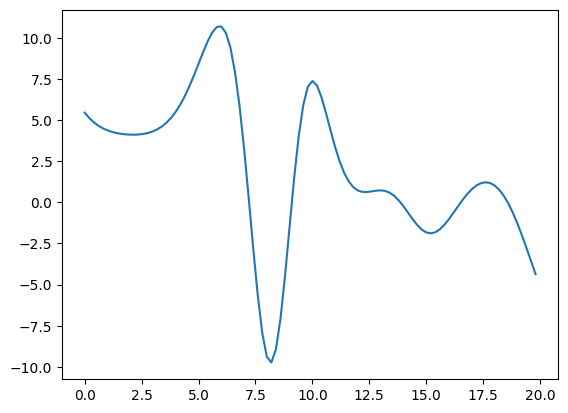

In [4]:
#np.random.seed(5)

def generate_gauss():
    
    """The function returns the Gaussian processes A(t) and P(t). 
         See Regazzoni et al."""
    
    mu = 0.0
    tau = 5.0
    sigma = 5.0
  
    # Covariance kernel function
    def covariance_kernel(t1, t2):
        return sigma**2 * np.exp(-((t1 - t2)**2) / (2 * tau**2))

    # Generate samples of A(t) and P(t) using the covariance kernel
    mean = mu*np.ones(N_TIME_STEPS)
    covariance_matrix = np.fromfunction(np.vectorize(lambda i, j: covariance_kernel(time_vector[i], time_vector[j])), (N_TIME_STEPS, N_TIME_STEPS), dtype=int)
    A_t = np.random.multivariate_normal(mean, covariance_matrix)
    P_t = np.random.multivariate_normal(mean, covariance_matrix)
   
    return A_t, P_t

A_t, P_t = generate_gauss()
u_t = A_t * np.cos(P_t)
plt.plot(time_vector, u_t)

def eval_u_t(t):
    return u_t[np.where(np.abs(time_vector - t) < 1e-3)[0][0]]




In [5]:
# Define an expression for the BC u_t
class u_t_Expression(fe.UserExpression):
    def __init__(self, t, **kwargs):
        super().__init__(**kwargs)
        self.t = t
    def eval(self, value, x):
        value[0] = eval_u_t(self.t)
        value[1] = 0.0
    def value_shape(self):
        return (2,) 

In [6]:
# Create XDMF files for visualization output
xdmffile_u = fe.XDMFFile('lid_cavity.xdmf')
xdmffile_p = fe.XDMFFile('lid_cavity_pressure.xdmf')
xdmffile_u.parameters["flush_output"] = True
xdmffile_u.parameters["functions_share_mesh"] = True
xdmffile_p.parameters["flush_output"] = True
xdmffile_p.parameters["functions_share_mesh"] = True


# Create time series (not clear its purpose)
# timeseries_u = fe.TimeSeries('velocity_series')
# timeseries_p = fe.TimeSeries('pressure_series')

In [7]:
def main():
    
    mesh = fe.UnitSquareMesh(N_POINTS_P_AXIS, N_POINTS_P_AXIS) # this is a triangular-element mesh
    
   
    # Taylor-Hood Elements. 
    velocity_function_space = fe.VectorFunctionSpace(mesh, "Lagrange", 2)
    pressure_function_space = fe.FunctionSpace(mesh, "Lagrange", 1)

    u_trial = fe.TrialFunction(velocity_function_space)
    p_trial = fe.TrialFunction(pressure_function_space)
    v_test = fe.TestFunction(velocity_function_space)
    q_test = fe.TestFunction(pressure_function_space)

    # Define the Boundary Condition
    stationary_wall_boundary_condition = fe.DirichletBC(
        velocity_function_space,
        (0.0, 0.0),
        """
        on_boundary && (x[0] < DOLFIN_EPS || x[1] < DOLFIN_EPS || x[0] > (1.0 - DOLFIN_EPS))
        """
    )

    g = u_t_Expression(t = 0.0, degree = 1) 
    moving_wall_boundary_condition = fe.DirichletBC(
        velocity_function_space,
        g,      #time-dependent expression for the velocity
        """
        on_boundary  && (x[1] > (1.0 - DOLFIN_EPS))
        """
        
    )

    # Put together the BCs
    velocity_boundary_conditions = [stationary_wall_boundary_condition, moving_wall_boundary_condition]

    # Define the solution fields involved
    u_prev = fe.Function(velocity_function_space)
    u_tent = fe.Function(velocity_function_space)
    u_next = fe.Function(velocity_function_space)
    p_next = fe.Function(pressure_function_space)

    # Weak form of the momentum equation
    momentum_weak_form_residuum = (
        1.0 / TIME_STEP_LENGTH * fe.inner(u_trial - u_prev, v_test) * fe.dx
        +
        fe.inner(fe.grad(u_prev) * u_prev, v_test) * fe.dx
        +
        KINEMATIC_VISCOSITY * fe.inner(fe.grad(u_trial), fe.grad(v_test)) * fe.dx
    )
    momentum_weak_form_lhs = fe.lhs(momentum_weak_form_residuum)
    momentum_weak_form_rhs = fe.rhs(momentum_weak_form_residuum)

    # Weak form of the pressure poisson problem
    pressure_poisson_weak_form_lhs = fe.inner(fe.grad(p_trial), fe.grad(q_test)) * fe.dx
    pressure_poisson_weak_form_rhs = - 1.0 / TIME_STEP_LENGTH * fe.div(u_tent) * q_test * fe.dx

    # Weak form of the velocity update equation
    velocity_update_weak_form_lhs = fe.inner(u_trial, v_test) * fe.dx
    velocity_update_weak_form_rhs = (
        fe.inner(u_tent, v_test) * fe.dx
        -
        TIME_STEP_LENGTH * fe.inner(fe.grad(p_next), v_test) * fe.dx
    )

    # Pre-Compute the system matrices 
    momentum_assembled_system_matrix = fe.assemble(momentum_weak_form_lhs)
    pressure_poisson_assembled_system_matrix = fe.assemble(pressure_poisson_weak_form_lhs)
    velocity_update_assembled_system_matrix = fe.assemble(velocity_update_weak_form_lhs)



    for t in tqdm(range(N_TIME_STEPS)):

        # Go back to "physical" time in order to correctly update the BC
        t = t*TOTAL_TIME/N_TIME_STEPS 
        
        
        g.t = t

        # Solve for tentative velocity
        momentum_assembled_rhs = fe.assemble(momentum_weak_form_rhs)
        [bc.apply(momentum_assembled_system_matrix, momentum_assembled_rhs) for bc in velocity_boundary_conditions]
        fe.solve(
            momentum_assembled_system_matrix,
            u_tent.vector(),
            momentum_assembled_rhs,
            "gmres",
            "ilu",
        )

        # Solve for the pressure
        pressure_poisson_assembled_rhs = fe.assemble(pressure_poisson_weak_form_rhs)
        fe.solve(
            pressure_poisson_assembled_system_matrix,
            p_next.vector(),
            pressure_poisson_assembled_rhs,
            # "gmres",
            # "amg",
        )

        # Correct the velocities to be incompressible
        [bc.apply(momentum_assembled_system_matrix, momentum_assembled_rhs) for bc in velocity_boundary_conditions]
        velocity_update_assembled_rhs = fe.assemble(velocity_update_weak_form_rhs)
        fe.solve(
            velocity_update_assembled_system_matrix,
            u_next.vector(),
            velocity_update_assembled_rhs,
            # "gmres",
            # "ilu",
        )

        # Advance in time
        u_prev.assign(u_next)
        
      
  
        xdmffile_u.write(u_next, t)
        xdmffile_p.write(p_next, t)

    # Save nodal values to file
        # timeseries_u.store(u_next.vector(), t)
        # timeseries_p.store(p_next.vector(), t)

        #Visualize interactively
#         c = fe.plot(u_next)
#         plt.colorbar(c)
#         plt.draw()
#         plt.pause(0.02)
#         plt.clf()
        

In [8]:
if __name__ == "__main__":
    main()

 11%|█         | 11/100 [00:19<02:38,  1.78s/it]


RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve linear system using PETSc Krylov solver.
*** Reason:  Solution failed to converge in 0 iterations (PETSc reason DIVERGED_NANORINF, residual norm ||r|| = inf).
*** Where:   This error was encountered inside PETScKrylovSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.1.0
*** Git changeset:  12ef077802cc9fad34cf984ec7af80585b44301b
*** -------------------------------------------------------------------------
